In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

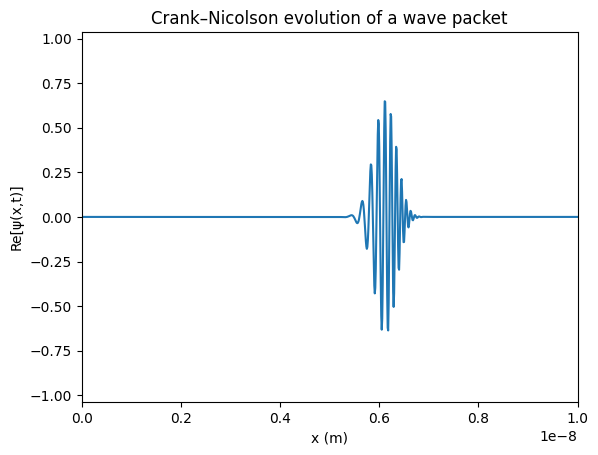

In [16]:
# ----------------- physical parameters -----------------
hbar  = 1.054571817e-34      # J·s
M     = 9.109e-31            # kg (electron mass)
L     = 1.0e-8               # m (box length)
N     = 1000                 # number of spatial intervals
a     = L / N                # spatial step
dt    = 1.0e-18              # time step

x0    = L / 2.0              # initial center
sigma = 1.0e-10              # width
kappa = 5.0e10               # wave number

# ----------------- grid & initial wavefunction -----------------
i  = np.arange(1, N)         # interior indices (0 and N are the walls)
x  = i * a                   # interior positions
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * kappa * x)

# ----------------- Crank–Nicolson matrices -----------------
a1 = 1.0 + 1j * hbar * dt / (2.0 * M * a**2)
a2 = -1j * hbar * dt / (4.0 * M * a**2)
b1 = 1.0 - 1j * hbar * dt / (2.0 * M * a**2)
b2 = 1j  * hbar * dt / (4.0 * M * a**2)

diag_A = np.full(N-1, a1, dtype=complex)
off_A  = np.full(N-2, a2, dtype=complex)
A = np.diag(diag_A) + np.diag(off_A, 1) + np.diag(off_A, -1)

diag_B = np.full(N-1, b1, dtype=complex)
off_B  = np.full(N-2, b2, dtype=complex)
B = np.diag(diag_B) + np.diag(off_B, 1) + np.diag(off_B, -1)

def crank_nicolson_step(psi):
    """One Crank–Nicolson time step."""
    v = B @ psi
    return np.linalg.solve(A, v)

# ----------------- set up the plot -----------------
fig, ax = plt.subplots()
line, = ax.plot(x, psi.real)

ax.set_xlim(0, L)
ax.set_ylim(-1.1*np.max(np.abs(psi.real)),
            1.1*np.max(np.abs(psi.real)))
ax.set_xlabel("x (m)")
ax.set_ylabel("Re[ψ(x,t)]")
ax.set_title("Crank–Nicolson evolution of a wave packet")

# number of frames in the animation
n_steps = 200

def update(frame):
    global psi
    psi = crank_nicolson_step(psi)
    line.set_ydata(psi.real)
    return line,

anim = FuncAnimation(fig, update, frames=n_steps, interval=30, blit=True)

# THIS LINE makes the animation show directly in the notebook:
HTML(anim.to_jshtml())


In [18]:
for n in range(n_steps):
    psi = crank_nicolson_step(psi)
    plt.figure()
    plt.plot(x, psi.real)
    plt.xlim(0, L)
    plt.ylim(-1.1*np.max(np.abs(psi.real)),1.1*np.max(np.abs(psi.real)))
    plt.xlabel("x (m)")
    plt.ylabel("Re[ψ(x,t)]")
    plt.title(f"Step {n}")
    plt.savefig(f"wave_function_{n:03d}.png")
    plt.close()


In [20]:
particles = np.loadtxt("particles.dat")
particles

array([[51.526619, 53.322742],
       [50.394722, 46.322815],
       [48.705956, 45.986626],
       ...,
       [66.786804, 62.917507],
       [41.081547, 69.211014],
       [58.269341, 69.498154]])

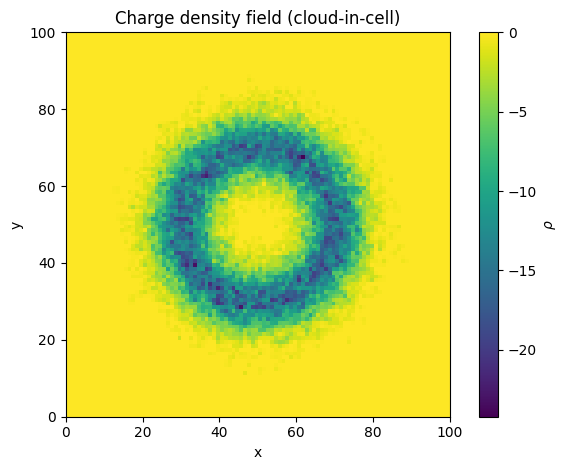

Jacobi relaxation converged in 47063 iterations


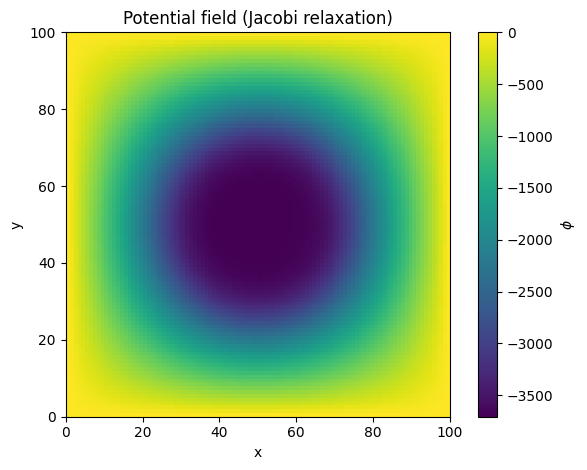

In [29]:
# ------------------- constants and grid -------------------
M = 100                         # grid size per side
L = 100.0                       # physical box size
h = L / M                       # grid spacing (should be 1.0 here)
eps0 = 1.0                      # you can set to actual epsilon_0 if you want

# grid cell centers
x = (np.arange(M) + 0.5) * h
y = (np.arange(M) + 0.5) * h
X, Y = np.meshgrid(x, y, indexing='ij')

# ------------------- (a) cloud-in-cell charge density -------------------

# Load particles: each row: x y
particles = np.loadtxt("particles.dat")   # shape (N, 2)
q_e = -1.0                                # each particle's charge; scale how you like

rho = np.zeros((M, M), dtype=float)       # charge density field

for xp, yp in particles:
    # positions relative to cell center grid
    u = xp / h - 0.5      # or simply xp - 0.5 when h=1
    v = yp / h - 0.5

    i = int(np.floor(u))
    j = int(np.floor(v))

    # skip if particle is at or outside the boundary
    if i < 0 or i >= M-1 or j < 0 or j >= M-1:
        continue

    dx = u - i
    dy = v - j

    w00 = (1 - dx) * (1 - dy)
    w10 = dx * (1 - dy)
    w01 = (1 - dx) * dy
    w11 = dx * dy

    rho[i,   j  ] += q_e * w00 / (h**2)
    rho[i+1, j  ] += q_e * w10 / (h**2)
    rho[i,   j+1] += q_e * w01 / (h**2)
    rho[i+1, j+1] += q_e * w11 / (h**2)

# Plot charge density
plt.figure()
plt.imshow(rho.T, origin='lower', extent=[0, L, 0, L])
plt.colorbar(label=r'$\rho$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge density field (cloud-in-cell)')
plt.tight_layout()
plt.savefig("Charge_density_field_(cloud-in-cell).png")
plt.show()

# ------------------- (b) Jacobi relaxation for Poisson -------------------

def jacobi_poisson(rho, tol=1e-10, max_iters=100000):
    phi = np.zeros_like(rho)
    phi_new = np.zeros_like(rho)

    Mx, My = rho.shape
    h2 = h**2

    for it in range(max_iters):
        # interior update
        phi_new[1:Mx-1, 1:My-1] = 0.25 * (
            phi[2:Mx,   1:My-1] +   # i+1
            phi[0:Mx-2, 1:My-1] +   # i-1
            phi[1:Mx-1, 2:My]   +   # j+1
            phi[1:Mx-1, 0:My-2] +   # j-1
            h2 * rho[1:Mx-1, 1:My-1] / eps0
        )

        # boundaries are grounded
        phi_new[0, :] = 0.0
        phi_new[-1,:] = 0.0
        phi_new[:, 0] = 0.0
        phi_new[:, -1] = 0.0

        diff = np.max(np.abs(phi_new - phi))
        phi, phi_new = phi_new, phi  # swap references

        if diff < tol:
            return phi, it + 1

    print("Jacobi did not converge within max_iters")
    return phi, max_iters

phi_jacobi, iters_jacobi = jacobi_poisson(rho)
print(f"Jacobi relaxation converged in {iters_jacobi} iterations")

# Plot potential from Jacobi
plt.figure()
plt.imshow(phi_jacobi.T, origin='lower', extent=[0, L, 0, L])
plt.colorbar(label=r'$\phi$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential field (Jacobi relaxation)')
plt.tight_layout()
plt.savefig("Potential_field_(Jacobi_relaxation).png")
plt.show()

Optimal omega ≈ 1.942
SOR with omega=1.942 converged in 456 iterations


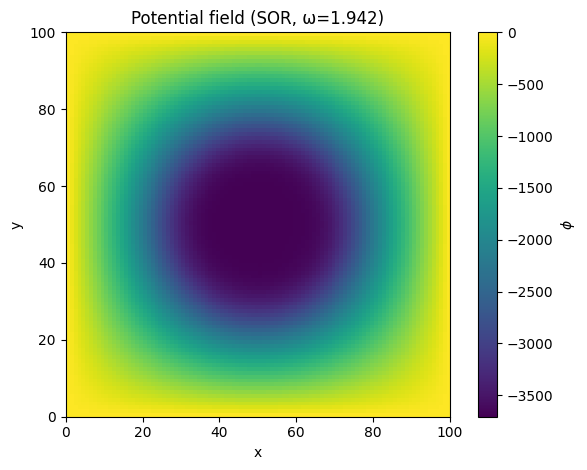

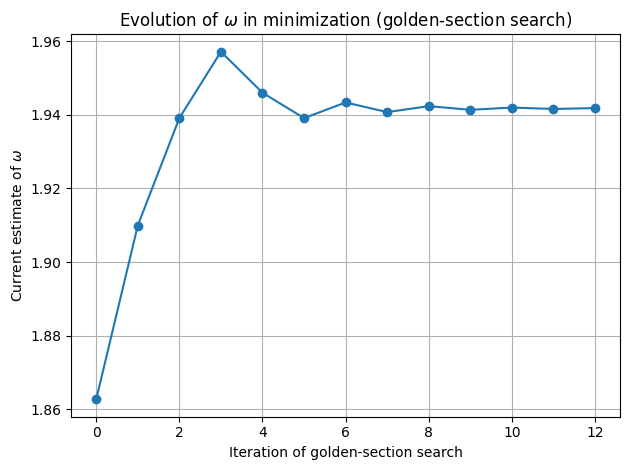

In [34]:
# ------------------- (c) FAST Gauss–Seidel over-relaxation (SOR) ---------

# Precompute masks for red/black checkerboard on the interior
Mx, My = rho.shape
Ni, Nj = Mx-2, My-2                       # number of interior points

ii = np.arange(Ni)[:, None]               # shape (Ni,1)
jj = np.arange(Nj)[None, :]               # shape (1,Nj)
red_mask   = ((ii + jj) % 2 == 0)
black_mask = ~red_mask

h2 = h**2

def sor_poisson_fast(rho, omega, tol=1e-10, max_iters=100000):
    """
    Red–black vectorized Gauss–Seidel SOR for Poisson.
    Boundary is fixed at 0 (grounded).
    """
    phi = np.zeros_like(rho, dtype=float)

    for it in range(max_iters):
        maxdiff = 0.0

        # ---------- RED update ----------
        phi_old = phi.copy()

        # neighbors using old phi
        ip1 = phi_old[2:,   1:-1]
        im1 = phi_old[:-2,  1:-1]
        jp1 = phi_old[1:-1, 2:  ]
        jm1 = phi_old[1:-1, :-2 ]

        phi_gs = 0.25 * (ip1 + im1 + jp1 + jm1 + h2 * rho[1:-1,1:-1] / eps0)

        interior = phi[1:-1, 1:-1]
        old_vals = interior[red_mask]
        new_vals = (1.0 - omega) * old_vals + omega * phi_gs[red_mask]
        interior[red_mask] = new_vals

        maxdiff = max(maxdiff, np.max(np.abs(new_vals - old_vals)))

        # ---------- BLACK update ----------
        phi_mid = phi.copy()

        ip1 = phi_mid[2:,   1:-1]
        im1 = phi_mid[:-2,  1:-1]
        jp1 = phi_mid[1:-1, 2:  ]
        jm1 = phi_mid[1:-1, :-2 ]

        phi_gs2 = 0.25 * (ip1 + im1 + jp1 + jm1 + h2 * rho[1:-1,1:-1] / eps0)

        interior_mid = phi_mid[1:-1, 1:-1]
        old_vals = interior_mid[black_mask]
        new_vals = (1.0 - omega) * old_vals + omega * phi_gs2[black_mask]
        interior_mid[black_mask] = new_vals
        phi[1:-1, 1:-1] = interior_mid

        maxdiff = max(maxdiff, np.max(np.abs(new_vals - old_vals)))

        if maxdiff < tol:
            return phi, it + 1

    return phi, max_iters


def iterations_for_omega(omega, rho):
    _, iters = sor_poisson_fast(rho, omega, tol=1e-10, max_iters=5000)
    return iters


# Golden-section search for optimal omega in a *narrow* interval
def golden_section_search(rho, tol=1e-3):
    phi = (np.sqrt(5) - 1) / 2  # ≈ 0.618

    # Use the theoretical approximate optimum as center:
    # ω ≈ 2 / (1 + sin(π/N)), N ~ number of grid points per side
    N = Mx
    omega0 = 2.0 / (1.0 + np.sin(np.pi / N))

    # Search only in a small band around that value
    a = max(0.2,  omega0 - 0.2)
    b = min(3.99, omega0 + 0.2)

    c = b - phi * (b - a)
    d = a + phi * (b - a)

    fc = iterations_for_omega(c, rho)
    fd = iterations_for_omega(d, rho)

    history = []

    while (b - a) > tol:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - phi * (b - a)
            fc = iterations_for_omega(c, rho)
        else:
            a, c, fc = c, d, fd
            d = a + phi * (b - a)
            fd = iterations_for_omega(d, rho)

        history.append((a + b) / 2.0)

    omega_opt = (a + b) / 2.0
    return omega_opt, history


# ---- run the search (fast) ----
omega_opt, omega_history = golden_section_search(rho)
print(f"Optimal omega ≈ {omega_opt:.3f}")

# Now solve once with the *strict* tolerance using the optimal omega
phi_sor, iters_sor = sor_poisson_fast(rho, omega_opt, tol=1e-10, max_iters=100000)
print(f"SOR with omega={omega_opt:.3f} converged in {iters_sor} iterations")

# Plot potential (SOR)
plt.figure()
plt.imshow(phi_sor.T, origin='lower', extent=[0, L, 0, L])
plt.colorbar(label=r'$\phi$')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Potential field (SOR, ω={omega_opt:.3f})')
plt.tight_layout()
plt.savefig(f'Potential_field_(SOR,ω={omega_opt:.3f}).png')
plt.show()

# Plot how omega evolves during the search
plt.figure()
plt.plot(omega_history, marker='o')
plt.xlabel('Iteration of golden-section search')
plt.ylabel(r'Current estimate of $\omega$')
plt.title(r'Evolution of $\omega$ in minimization (golden-section search)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Evolution_of_omega_in_minimization_(golden-section-search).png')
plt.show()